## Download DICOM images

We will download the DICOM images and save them as .npz files

A total of 900 patients data (125 GB of DICOM) was downloaded and the final size of the saved .npz files were only 74GB

The code loops over 10 patients at a time, downloads their CT images, converts them into .npz and cleans up the directory

The data is saved in a new disk (100 GB) mounted into /mnt/disks/data

In [ ]:
#### Install the pidicom libraries

In [1]:
#!git clone https://github.com/pieper/dicomsort.git
!pip install pydicom
!pip install pylidc
!pip install google-cloud-bigquery
!pip install --upgrade google-auth-oauthlib
!pip install --upgrade 'google-cloud-bigquery[bqstorage,pandas]'
#!python dicomsort/dicomsort.py --help

     |████████████████████████████████| 2.0 MB 8.3 MB/s eta 0:00:01
     |████████████████████████████████| 5.6 MB 6.7 MB/s eta 0:00:01
     |████████████████████████████████| 30.2 MB 29.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 64.2 MB/s eta 0:00:01
     |████████████████████████████████| 4.4 MB 63.5 MB/s eta 0:00:01
     |████████████████████████████████| 178 kB 92.8 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 72.3 MB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 54.1 MB/s eta 0:00:01
     |████████████████████████████████| 156 kB 92.0 MB/s eta 0:00:01
  Attempting uninstall: pillow
    Found existing installation: Pillow 8.2.0
    Uninstalling Pillow-8.2.0:
      Successfully uninstalled Pillow-8.2.0
     |████████████████████████████████| 203 kB 6.9 MB/s eta 0:00:01
     |████████████████████████████████| 45 kB 6.1 MB/s  eta 0:00:01
     |████████████████████████████████| 95 kB 8.4 MB/s  eta 0:00:01
     |██████████████████

In [1]:
%load_ext google.cloud.bigquery

In [2]:
!git clone https://github.com/pieper/dicomsort.git

fatal: destination path 'dicomsort' already exists and is not an empty directory.


In [3]:
import pylidc as pl
from pylidc.utils import consensus
import pydicom as dicom
from skimage.measure import find_contours
import numpy as np
import matplotlib.pyplot as plt

In [4]:
pl.query(pl.Scan).count()
pid = 'LIDC-IDRI-0069'#'LIDC-IDRI-0001'
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).first()
scan.study_instance_uid

'1.3.6.1.4.1.14519.5.2.1.6279.6001.303241414168367763244410429787'

In [5]:
from google_auth_oauthlib import flow

# TODO: Uncomment the line below to set the `launch_browser` variable.
launch_browser = False
#
# The `launch_browser` boolean variable indicates if a local server is used
# as the callback URL in the auth flow. A value of `True` is recommended,
# but a local server does not work if accessing the application remotely,
# such as over SSH or from a remote Jupyter notebook.

appflow = flow.InstalledAppFlow.from_client_secrets_file(
    "client_secret_desktop.json", scopes=["https://www.googleapis.com/auth/bigquery"]
)

if launch_browser:
    appflow.run_local_server()
else:
    appflow.run_console()

credentials = appflow.credentials

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=354066013909-il5lh54dbass54iv45m7thff0uuefjar.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery&state=JybFkpt3tA5gAurrY5Bkly1MoU46VF&prompt=consent&access_type=offline


Enter the authorization code:  4/1AX4XfWiozFdsiX4rrkiyzJcWrYfBdpFkmAY-nm4fbBk4qGBDXXwLyjWsbr4


In [6]:
from google.cloud.bigquery import magics
magics.context.credentials = credentials

In [8]:
myProjectID = "idc-external-012" #"positive-sector-330514" #"idc-external-012"

In [9]:
%%bigquery CT_series --project=$myProjectID 

WITH
  all_lidc_ct_series AS (
  SELECT
    DISTINCT(SeriesInstanceUID),
    StudyInstanceUID,  
    PatientID,
    SliceThickness,
    ARRAY_TO_STRING(PixelSpacing,"/") as pixelspa 
  FROM
    `canceridc-data.idc_views.dicom_all`
  WHERE
    Modality = "CT"
    AND collection_id = "lidc_idri")
SELECT PatientID,SliceThickness,pixelspa,StudyInstanceUID,SeriesInstanceUID FROM
  all_lidc_ct_series
ORDER BY
  PatientID

Downloading: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1018/1018 [00:01<00:00, 628.82rows/s]


In [10]:
total_patients = len(np.unique(CT_series['PatientID']))
chosen_patients = len(np.unique(CT_series[(CT_series["SliceThickness"].astype(float)>=1.0)]['PatientID']))
print("Choosing patients with slice thickness > 1.0")
print("Total patients is {} and chosen patients are {}".format(total_patients, chosen_patients))

Choosing patients with slice thickness > 1.0
Total patients is 1010 and chosen patients are 971


In [11]:
import pandas as pd
# s_1,s_2,s_3 = 5,5,5
# ct_series_1 = CT_series[CT_series["SliceThickness"].astype(float)==1.0]
# ct_series_2 = CT_series[CT_series["SliceThickness"].astype(float)==2.0]
# ct_series_3 = CT_series[CT_series["SliceThickness"].astype(float)==3.0]
# ct_series_HR = pd.concat([ct_series_1[:s_1],ct_series_2[:s_2],ct_series_3[:s_3]])
ct_series_HR = CT_series[(CT_series["SliceThickness"].astype(float)>=1.0)]
print("Shape of the raw dataset is {}".format(ct_series_HR.shape))

Shape of the raw dataset is (979, 5)


In [12]:
to_download = []
base_gs_uri = 'gs://idc-tcia-lidc-idri/dicom/'

for i in range(ct_series_HR.shape[0]):
    to_download.append(base_gs_uri + ct_series_HR.iloc[i]['StudyInstanceUID'] + '/' + ct_series_HR.iloc[i]['SeriesInstanceUID'])

manifest_df = pd.DataFrame({"gcs":to_download},columns=["gcs"])

In [13]:
manifest_df.to_csv("gcs_paths_all.txt",header=False, index=False)
!head gcs_paths_all.txt

gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288633453246975630178/1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636438705059720603192
gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.490157381160200744295382098329/1.3.6.1.4.1.14519.5.2.1.6279.6001.619372068417051974713149104919
gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.101370605276577556143013894866/1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615202213033480003264
gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.191425307197546732281885591780/1.3.6.1.4.1.14519.5.2.1.6279.6001.323541312620128092852212458228
gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.190188259083742759886805142125/1.3.6.1.4.1.14519.5.2.1.6279.6001.129007566048223160327836686225
gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.324680252006411183918098592500/1.3.6.1.4.1.14519.5.2.1.6279.6001.132817748896065918417924920957
gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.

In [14]:
!pip install gsutil

     |████████████████████████████████| 2.9 MB 8.1 MB/s eta 0:00:01
     |████████████████████████████████| 89 kB 15.2 MB/s eta 0:00:01
     |████████████████████████████████| 135 kB 64.9 MB/s eta 0:00:01
     |████████████████████████████████| 96 kB 9.9 MB/s  eta 0:00:01
     |████████████████████████████████| 1.4 MB 59.4 MB/s eta 0:00:01
     |████████████████████████████████| 98 kB 13.3 MB/s  eta 0:00:01
  Created wheel for gsutil: filename=gsutil-5.4-py3-none-any.whl size=3715191 sha256=8fa47c2ef6d11206648164896f7ae63bf005c98af3e75d87880601139862f86e
  Stored in directory: /root/.cache/pip/wheels/dc/7c/63/8cf44cb0431ae369e2c158cbbefa036b38bfa94bd707ab653e
  Created wheel for crcmod: filename=crcmod-1.7-cp38-cp38-linux_x86_64.whl size=35920 sha256=37dcfcb9abf1c756fdad136468852da7629c5c5ffe824a1d77057b571377d7ff
  Stored in directory: /root/.cache/pip/wheels/ca/5a/02/f3acf982a026f3319fb3e798a8dca2d48fafee7761788562e9
  Created wheel for gcs-oauth2-boto-plugin: filename=gcs_oauth2_bot

In [89]:
root_dir = '/rawdata/all/train'

In [13]:
!rm -rf data/temp/gcsfiles/
!rm -rf data/temp/sorted_gcsfiles/

In [76]:
import os
from tqdm import tqdm
# this directory will be created in the downloader but never deletedn entirely, only contents would be cleared
data_folder = '/rawdata/temp/sorted_gcsfiles/'

In [21]:
patient_list = os.listdir(data_folder)

FileNotFoundError: [Errno 2] No such file or directory: 'data/temp/sorted_gcsfiles/'

In [71]:
class RedirectStdStreams(object):
    def __init__(self, stdout=None, stderr=None):
        self._stdout = stdout or sys.stdout
        self._stderr = stderr or sys.stderr

    def __enter__(self):
        self.old_stdout, self.old_stderr = sys.stdout, sys.stderr
        self.old_stdout.flush(); self.old_stderr.flush()
        sys.stdout, sys.stderr = self._stdout, self._stderr

    def __exit__(self, exc_type, exc_value, traceback):
        self._stdout.flush(); self._stderr.flush()
        sys.stdout = self.old_stdout
        sys.stderr = self.old_stderr

In [118]:
from PIL import Image
import contextlib
import os
import imageio
from __future__ import print_function
import sys
from contextlib import redirect_stdout, redirect_stderr

devnull = open(os.devnull, 'w')

def save_patient_images_and_masks(patient_id, root_dir='/rawdata/all/train'):
    scan = pl.query(pl.Scan).filter(pl.Scan.patient_id.in_([patient_id]))[0]
    nodules_annotation = scan.cluster_annotations()
    with contextlib.redirect_stdout(None):
        vol = scan.to_volume()
        
    cmask_CT = []
    cbbox_CT = []
    masks_CT = []
    for nodule_idx, nodule in enumerate(nodules_annotation):
        cmask, cbbox, masks = consensus(nodule)
        cmask_CT.append(cmask)
        cbbox_CT.append(cbbox)
        masks_CT.append(masks)

    CT_mask = np.zeros_like(vol)    
    nodule_num = len(cmask_CT)

    for i in range(nodule_num):
        cmask = cmask_CT[i]
        cbbox = cbbox_CT[i]
        masks = masks_CT[i]    
        CT_mask[cbbox] += cmask

    for slice_id in range(vol.shape[2]):
        image = vol[:,:,slice_id]
        mask = CT_mask[:,:,slice_id]
        image_file_name = root_dir + "/images/" + "img" + "_" + str(patient_id) + "_" + str(slice_id) + ".jpg"
        mask_file_name = root_dir + "/masks/" + "mask" + "_" + str(patient_id) + "_" + str(slice_id) + ".jpg"
        with RedirectStdStreams(stdout=devnull, stderr=devnull):
            imageio.imwrite(image_file_name, image)
        with RedirectStdStreams(stdout=devnull, stderr=devnull):
            imageio.imwrite(mask_file_name, mask)
#         np.savez_compressed(image_file_name, image)
#         np.savez_compressed(mask_file_name, mask)

In [19]:
!df -h /rawdata

Filesystem      Size  Used Avail Use% Mounted on
/dev/sdc        147G   61M  147G   1% /rawdata


In [74]:
root_dir = '/rawdata/all/train'
def patient_data_as_jpg_files(sorted_data_dir):
    #get patient list
    patient_list = os.listdir(sorted_data_dir)
    if not os.path.exists(root_dir):
        print("Creating directory {}".format(root_dir))
        os.makedirs(root_dir)
    if not os.path.exists(root_dir + "/images/"):
        print("Creating directory {}".format(root_dir + "/images/"))
        os.makedirs(root_dir + "/images/")
    if not os.path.exists(root_dir + "/masks/"):
        print("Creating directory {}".format(root_dir + "/masks/"))
        os.makedirs(root_dir + "/masks/")
    for i in tqdm(range(len(patient_list))):
        try:
            save_patient_images_and_masks(patient_list[i], root_dir)
        except:
            print("Error getting DICOM files for patient {}, skipping".format(patient_list[i]))

In [90]:
def patient_data_as_npz_files():
    #get patient list
    patient_list = os.listdir(data_folder)
    if not os.path.exists(root_dir):
        print("Creating directory {}".format(root_dir))
        os.makedirs(root_dir)
    if not os.path.exists(root_dir + "/images/"):
        print("Creating directory {}".format(root_dir + "/images/"))
        os.makedirs(root_dir + "/images/")
    if not os.path.exists(root_dir + "/masks/"):
        print("Creating directory {}".format(root_dir + "/masks/"))
        os.makedirs(root_dir + "/masks/")
    print("Saving patient .npz files to {}".format(root_dir))
    for i in tqdm(range(len(patient_list))):
        try:
            save_patient_images_and_masks(patient_list[i], root_dir)
        except:
            print("Error getting DICOM files for patient {}, skipping".format(patient_list[i]))

In [116]:
# clean start
!rm -rf /rawdata/temp/gcsfiles/
!rm -rf /rawdata/temp/sorted_gcsfiles/

In [120]:
import os, shutil
import glob
download_dir = '/rawdata/temp/gcsfiles/'
sorted_dir = '/rawdata/temp/sorted_gcsfiles/'

if not os.path.exists(download_dir):
    print("Creating directory {}".format(download_dir))
    os.makedirs(download_dir)
else:
    print("Directory {} exists".format(download_dir))

if not os.path.exists(sorted_dir):
    print("Creating directory {}".format(sorted_dir))
    os.makedirs(sorted_dir)
else:
    print("Directory {} exists".format(sorted_dir))

for i in tqdm(range(manifest_df.shape[0])):
    url = manifest_df.iloc[i].gcs
    download_command = "gsutil -u {} -m cp -r {} {} >/dev/null 2>&1".format(myProjectID, url, download_dir)
    os.system(download_command)
    if (i > 1) and (i % 10 == 0): # got 10 patients
       # sort the images
       # !python dicomsort/dicomsort.py -u downloaded_cohort_3 cohort_sorted_3/%PatientID/%StudyInstanceUID/%SeriesInstanceUID/%SOPInstanceUID.dcm
        sort_command = "python dicomsort/dicomsort.py -u {} {}/%PatientID/%StudyInstanceUID/%SeriesInstanceUID/%SOPInstanceUID.dcm".format(download_dir, sorted_dir)
        os.system(sort_command)
        # todo: remove the download_dir contents
        print("Cleaning up downloaded DICOM files...")
        files = glob.glob(download_dir + "/*")
        for i in tqdm(range(len(files))):
            if os.path.isdir(files[i]):
                shutil.rmtree(files[i])
        print("Saving patient data as .npz file...")
        patient_data_as_jpg_files(sorted_dir)
        # todo: remove the sorted_dir contents
        print("Cleaning up sorted DICOM files...")
        files = glob.glob(sorted_dir + "/*")
        for i in tqdm(range(len(files))):
            if os.path.isdir(files[i]):
                shutil.rmtree(files[i])
        print("Collected {} images in {}".format(len(os.listdir(root_dir + '/images')), root_dir + '/images'))

Directory /rawdata/temp/gcsfiles/ exists
Directory /rawdata/temp/sorted_gcsfiles/ exists


100%|██████████| 1980/1980 [00:03<00:00, 548.25it/s]                                                                          | 10/979 [00:31<54:24,  3.37s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 67.22it/s]


Saving patient data as .npz file...
Creating directory /rawdata/all/train
Creating directory /rawdata/all/train/images/
Creating directory /rawdata/all/train/masks/



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:58<00:00,  5.29s/it]


Cleaning up sorted DICOM files...



  1%|█▎                                                                                                                     | 11/979 [01:36<5:58:33, 22.22s/it]

Collected 1980 images in /rawdata/all/train/images


100%|██████████| 1761/1761 [00:03<00:00, 555.82it/s]                                                                        | 20/979 [02:08<1:15:37,  4.73s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 70.69it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:52<00:00,  5.27s/it]


Cleaning up sorted DICOM files...



  2%|██▌                                                                                                                    | 21/979 [03:08<5:38:57, 21.23s/it]

Collected 3741 images in /rawdata/all/train/images


100%|██████████| 1724/1724 [00:03<00:00, 538.73it/s]                                                                        | 30/979 [03:40<1:06:50,  4.23s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 69.23it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:45<00:00,  4.58s/it]


Cleaning up sorted DICOM files...



  3%|███▊                                                                                                                   | 31/979 [04:32<4:55:43, 18.72s/it]

Collected 5465 images in /rawdata/all/train/images


100%|██████████| 1882/1882 [00:03<00:00, 545.73it/s]                                                                        | 40/979 [05:06<1:03:23,  4.05s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 63.13it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:49<00:00,  4.97s/it]


Cleaning up sorted DICOM files...



  4%|████▉                                                                                                                  | 41/979 [06:03<5:10:16, 19.85s/it]

Collected 7347 images in /rawdata/all/train/images


100%|██████████| 1479/1479 [00:02<00:00, 519.86it/s]                                                                        | 50/979 [06:32<1:01:00,  3.94s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 74.17it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:51<00:00,  5.17s/it]


Cleaning up sorted DICOM files...



  5%|██████▏                                                                                                                | 51/979 [07:30<5:11:38, 20.15s/it]

Collected 8826 images in /rawdata/all/train/images


100%|██████████| 1649/1649 [00:03<00:00, 545.85it/s]                                                                          | 60/979 [08:01<59:24,  3.88s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 74.60it/s]


Saving patient data as .npz file...



 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 9/10 [00:45<00:05,  5.18s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:50<00:00,  5.00s/it]


Cleaning up sorted DICOM files...



  6%|███████▍                                                                                                               | 61/979 [08:57<5:00:13, 19.62s/it]

Collected 10475 images in /rawdata/all/train/images


100%|██████████| 1960/1960 [00:03<00:00, 556.87it/s]                                                                        | 70/979 [09:29<1:06:21,  4.38s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 62.45it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:56<00:00,  5.65s/it]


Cleaning up sorted DICOM files...



  7%|████████▋                                                                                                              | 71/979 [10:35<5:45:12, 22.81s/it]

Collected 12435 images in /rawdata/all/train/images


100%|██████████| 1749/1749 [00:03<00:00, 552.96it/s]                                                                        | 80/979 [11:06<1:01:46,  4.12s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 68.64it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:50<00:00,  5.02s/it]


Cleaning up sorted DICOM files...



  8%|█████████▊                                                                                                             | 81/979 [12:04<5:05:27, 20.41s/it]

Collected 14184 images in /rawdata/all/train/images


100%|██████████| 1987/1987 [00:03<00:00, 566.36it/s]                                                                        | 90/979 [12:38<1:02:20,  4.21s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 63.57it/s]


Saving patient data as .npz file...



 20%|████████████████████████▌                                                                                                  | 2/10 [00:10<00:39,  4.95s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:55<00:00,  5.52s/it]


Cleaning up sorted DICOM files...



  9%|███████████                                                                                                            | 91/979 [13:41<5:26:40, 22.07s/it]

Collected 16170 images in /rawdata/all/train/images


100%|██████████| 2085/2085 [00:03<00:00, 539.66it/s]                                                                       | 100/979 [14:17<1:05:35,  4.48s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 55.88it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:56<00:00,  5.70s/it]


Cleaning up sorted DICOM files...



 10%|████████████▏                                                                                                         | 101/979 [15:22<5:29:29, 22.52s/it]

Collected 18255 images in /rawdata/all/train/images


100%|██████████| 1411/1411 [00:02<00:00, 548.20it/s]                                                                         | 110/979 [15:50<58:07,  4.01s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 84.58it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:40<00:00,  4.06s/it]


Cleaning up sorted DICOM files...



 11%|█████████████▍                                                                                                        | 111/979 [16:37<4:02:18, 16.75s/it]

Collected 19666 images in /rawdata/all/train/images


100%|██████████| 1915/1915 [00:03<00:00, 561.23it/s]                                                                       | 120/979 [17:12<1:10:28,  4.92s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 64.12it/s]


Saving patient data as .npz file...



 50%|█████████████████████████████████████████████████████████████▌                                                             | 5/10 [00:25<00:20,  4.13s/it]

Error getting DICOM files for patient LIDC-IDRI-0120, skipping



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:49<00:00,  4.90s/it]


Cleaning up sorted DICOM files...



 12%|██████████████▌                                                                                                       | 121/979 [18:08<4:48:35, 20.18s/it]

Collected 21399 images in /rawdata/all/train/images


100%|██████████| 1992/1992 [00:03<00:00, 548.08it/s]                                                                       | 130/979 [18:41<1:06:12,  4.68s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 62.20it/s]


Saving patient data as .npz file...



 70%|██████████████████████████████████████████████████████████████████████████████████████                                     | 7/10 [00:43<00:15,  5.20s/it]

Error getting DICOM files for patient LIDC-IDRI-0132, skipping



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:58<00:00,  5.81s/it]


Cleaning up sorted DICOM files...



 13%|███████████████▊                                                                                                      | 131/979 [19:46<5:21:57, 22.78s/it]

Collected 23275 images in /rawdata/all/train/images


100%|██████████| 1996/1996 [00:03<00:00, 548.92it/s]                                                                       | 140/979 [20:18<1:06:50,  4.78s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 61.30it/s]

Saving patient data as .npz file...




 40%|█████████████████████████████████████████████████▏                                                                         | 4/10 [00:18<00:29,  4.98s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:00<00:00,  6.10s/it]


Cleaning up sorted DICOM files...



 14%|████████████████▉                                                                                                     | 141/979 [21:29<5:43:59, 24.63s/it]

Collected 25271 images in /rawdata/all/train/images


100%|██████████| 1450/1450 [00:02<00:00, 568.48it/s]                                                                         | 150/979 [21:56<50:52,  3.68s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 79.29it/s]


Saving patient data as .npz file...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:38<00:00,  4.26s/it]


Cleaning up sorted DICOM files...



 15%|██████████████████▏                                                                                                   | 151/979 [22:40<3:38:00, 15.80s/it]

Collected 26608 images in /rawdata/all/train/images


100%|██████████| 1666/1666 [00:02<00:00, 570.77it/s]                                                                         | 160/979 [23:09<50:30,  3.70s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 73.40it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:46<00:00,  4.62s/it]


Cleaning up sorted DICOM files...



 16%|███████████████████▍                                                                                                  | 161/979 [24:03<4:16:18, 18.80s/it]

Collected 28274 images in /rawdata/all/train/images


100%|██████████| 1694/1694 [00:03<00:00, 555.74it/s]                                                                         | 170/979 [24:34<57:43,  4.28s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 66.25it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:54<00:00,  5.45s/it]


Cleaning up sorted DICOM files...



 17%|████████████████████▌                                                                                                 | 171/979 [25:35<4:45:15, 21.18s/it]

Collected 29968 images in /rawdata/all/train/images


100%|██████████| 1519/1519 [00:02<00:00, 570.37it/s]                                                                         | 180/979 [26:03<53:03,  3.98s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 78.47it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:44<00:00,  4.42s/it]


Cleaning up sorted DICOM files...



 18%|█████████████████████▊                                                                                                | 181/979 [26:54<3:58:12, 17.91s/it]

Collected 31487 images in /rawdata/all/train/images


100%|██████████| 1315/1315 [00:02<00:00, 553.72it/s]                                                                         | 190/979 [27:21<52:02,  3.96s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 91.92it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:40<00:00,  4.01s/it]


Cleaning up sorted DICOM files...



 20%|███████████████████████                                                                                               | 191/979 [28:07<3:37:43, 16.58s/it]

Collected 32802 images in /rawdata/all/train/images


100%|██████████| 1531/1531 [00:02<00:00, 571.02it/s]                                                                         | 200/979 [28:35<47:13,  3.64s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 79.25it/s]


Saving patient data as .npz file...



 40%|█████████████████████████████████████████████████▏                                                                         | 4/10 [00:20<00:32,  5.36s/it]

Error getting DICOM files for patient LIDC-IDRI-0199, skipping



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:45<00:00,  4.51s/it]


Cleaning up sorted DICOM files...



 21%|████████████████████████▏                                                                                             | 201/979 [29:26<3:51:54, 17.88s/it]

Collected 34318 images in /rawdata/all/train/images


100%|██████████| 1673/1673 [00:03<00:00, 556.19it/s]                                                                         | 210/979 [29:56<48:51,  3.81s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 71.72it/s]


Saving patient data as .npz file...



  0%|                                                                                                                                   | 0/10 [00:00<?, ?it/s]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:48<00:00,  4.82s/it]


Cleaning up sorted DICOM files...



 22%|█████████████████████████▍                                                                                            | 211/979 [30:52<4:08:30, 19.41s/it]

Collected 35991 images in /rawdata/all/train/images


100%|██████████| 1648/1648 [00:02<00:00, 556.73it/s]                                                                         | 220/979 [31:22<53:12,  4.21s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 74.03it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:45<00:00,  4.60s/it]


Cleaning up sorted DICOM files...



 23%|██████████████████████████▋                                                                                           | 221/979 [32:15<3:56:27, 18.72s/it]

Collected 37639 images in /rawdata/all/train/images


100%|██████████| 1421/1421 [00:02<00:00, 553.88it/s]                                                                         | 230/979 [32:42<44:17,  3.55s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 86.22it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:40<00:00,  4.08s/it]


Cleaning up sorted DICOM files...



 24%|███████████████████████████▊                                                                                          | 231/979 [33:29<3:26:38, 16.58s/it]

Collected 39060 images in /rawdata/all/train/images


100%|██████████| 1558/1558 [00:02<00:00, 562.16it/s]                                                                         | 240/979 [33:58<50:08,  4.07s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 77.86it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:44<00:00,  4.43s/it]


Cleaning up sorted DICOM files...



 25%|█████████████████████████████                                                                                         | 241/979 [34:48<3:42:00, 18.05s/it]

Collected 40618 images in /rawdata/all/train/images


100%|██████████| 1418/1418 [00:02<00:00, 560.58it/s]                                                                         | 250/979 [35:15<44:25,  3.66s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 83.57it/s]


Saving patient data as .npz file...



 20%|████████████████████████▌                                                                                                  | 2/10 [00:08<00:32,  4.05s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:40<00:00,  4.03s/it]


Cleaning up sorted DICOM files...



 26%|██████████████████████████████▎                                                                                       | 251/979 [36:02<3:19:57, 16.48s/it]

Collected 42036 images in /rawdata/all/train/images


100%|██████████| 1401/1401 [00:02<00:00, 562.10it/s]                                                                         | 260/979 [36:27<41:39,  3.48s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 82.30it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:39<00:00,  3.98s/it]


Cleaning up sorted DICOM files...



 27%|███████████████████████████████▍                                                                                      | 261/979 [37:14<3:15:37, 16.35s/it]

Collected 43437 images in /rawdata/all/train/images


100%|██████████| 1685/1685 [00:02<00:00, 570.56it/s]                                                                         | 270/979 [37:45<44:18,  3.75s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 73.13it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:45<00:00,  4.54s/it]


Cleaning up sorted DICOM files...



 28%|████████████████████████████████▋                                                                                     | 271/979 [38:36<3:33:50, 18.12s/it]

Collected 45122 images in /rawdata/all/train/images


100%|██████████| 1479/1479 [00:02<00:00, 571.56it/s]                                                                         | 280/979 [39:05<44:37,  3.83s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 81.18it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:39<00:00,  3.95s/it]


Cleaning up sorted DICOM files...



 29%|█████████████████████████████████▊                                                                                    | 281/979 [39:50<3:09:20, 16.28s/it]

Collected 46601 images in /rawdata/all/train/images


100%|██████████| 1906/1906 [00:03<00:00, 582.54it/s]                                                                         | 290/979 [40:20<49:41,  4.33s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 63.70it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:51<00:00,  5.16s/it]


Cleaning up sorted DICOM files...



 30%|███████████████████████████████████                                                                                   | 291/979 [41:23<4:12:00, 21.98s/it]

Collected 48507 images in /rawdata/all/train/images


100%|██████████| 3422/3422 [00:06<00:00, 561.09it/s]                                                                       | 300/979 [42:16<1:22:32,  7.29s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 37.11it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:32<00:00,  9.20s/it]


Cleaning up sorted DICOM files...



 31%|████████████████████████████████████▎                                                                                 | 301/979 [43:58<6:42:44, 35.64s/it]

Collected 51929 images in /rawdata/all/train/images


100%|██████████| 2465/2465 [00:04<00:00, 582.81it/s]                                                                         | 310/979 [44:35<58:54,  5.28s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 51.60it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:07<00:00,  6.72s/it]


Cleaning up sorted DICOM files...



 32%|█████████████████████████████████████▍                                                                                | 311/979 [45:51<4:55:56, 26.58s/it]

Collected 54394 images in /rawdata/all/train/images


100%|██████████| 1713/1713 [00:02<00:00, 581.63it/s]                                                                         | 320/979 [46:21<46:48,  4.26s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 70.68it/s]


Saving patient data as .npz file...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:44<00:00,  4.90s/it]


Cleaning up sorted DICOM files...



 33%|██████████████████████████████████████▋                                                                               | 321/979 [47:11<3:17:53, 18.04s/it]

Collected 55990 images in /rawdata/all/train/images


100%|██████████| 2704/2704 [00:04<00:00, 576.46it/s]                                                                         | 330/979 [47:54<54:39,  5.05s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 46.25it/s]


Saving patient data as .npz file...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:02<00:00,  6.93s/it]


Cleaning up sorted DICOM files...



 34%|███████████████████████████████████████▉                                                                              | 331/979 [49:05<4:29:04, 24.91s/it]

Collected 58402 images in /rawdata/all/train/images


100%|██████████| 2288/2288 [00:03<00:00, 586.54it/s]                                                                         | 340/979 [49:43<57:45,  5.42s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 54.16it/s]


Saving patient data as .npz file...



 40%|█████████████████████████████████████████████████▏                                                                         | 4/10 [00:22<00:30,  5.05s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:07<00:00,  6.78s/it]


Cleaning up sorted DICOM files...



 35%|█████████████████████████████████████████                                                                             | 341/979 [50:58<4:40:06, 26.34s/it]

Collected 60690 images in /rawdata/all/train/images


100%|██████████| 1914/1914 [00:03<00:00, 554.90it/s]                                                                         | 350/979 [51:30<48:47,  4.65s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 58.99it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:54<00:00,  5.42s/it]


Cleaning up sorted DICOM files...



 36%|██████████████████████████████████████████▎                                                                           | 351/979 [52:33<3:51:52, 22.15s/it]

Collected 62604 images in /rawdata/all/train/images


100%|██████████| 1841/1841 [00:03<00:00, 575.16it/s]                                                                         | 360/979 [53:04<47:28,  4.60s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 67.92it/s]


Saving patient data as .npz file...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:48<00:00,  5.40s/it]


Cleaning up sorted DICOM files...



 37%|███████████████████████████████████████████▌                                                                          | 361/979 [54:00<3:26:10, 20.02s/it]

Collected 64324 images in /rawdata/all/train/images


100%|██████████| 2469/2469 [00:04<00:00, 587.46it/s]                                                                         | 370/979 [54:35<54:41,  5.39s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 49.13it/s]


Saving patient data as .npz file...



 44%|███████████████████████████████████████████████████████                                                                     | 4/9 [00:35<00:42,  8.41s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:03<00:00,  7.03s/it]


Cleaning up sorted DICOM files...



 38%|████████████████████████████████████████████▋                                                                         | 371/979 [55:50<4:27:13, 26.37s/it]

Collected 66695 images in /rawdata/all/train/images


100%|██████████| 2793/2793 [00:05<00:00, 555.24it/s]                                                                         | 380/979 [56:34<47:58,  4.81s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 40.95it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:15<00:00,  7.57s/it]


Cleaning up sorted DICOM files...



 39%|█████████████████████████████████████████████▉                                                                        | 381/979 [57:58<4:44:16, 28.52s/it]

Collected 69488 images in /rawdata/all/train/images


100%|██████████| 2496/2496 [00:04<00:00, 569.80it/s]▊                                                                        | 390/979 [58:38<46:39,  4.75s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 49.01it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:09<00:00,  6.93s/it]


Cleaning up sorted DICOM files...



 40%|███████████████████████████████████████████████▏                                                                      | 391/979 [59:55<4:19:57, 26.53s/it]

Collected 71984 images in /rawdata/all/train/images


100%|██████████| 2282/2282 [00:03<00:00, 570.56it/s]█▏                                                                     | 400/979 [1:00:32<49:05,  5.09s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 53.89it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:05<00:00,  6.51s/it]


Cleaning up sorted DICOM files...



 41%|███████████████████████████████████████████████▌                                                                    | 401/979 [1:01:45<4:04:09, 25.35s/it]

Collected 74266 images in /rawdata/all/train/images


100%|██████████| 2955/2955 [00:05<00:00, 567.09it/s]██▍                                                                    | 410/979 [1:02:26<46:28,  4.90s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 39.67it/s]


Saving patient data as .npz file...



 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 9/10 [01:15<00:08,  8.72s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:24<00:00,  8.43s/it]


Cleaning up sorted DICOM files...



 42%|████████████████████████████████████████████████▋                                                                   | 411/979 [1:04:03<5:08:47, 32.62s/it]

Collected 77221 images in /rawdata/all/train/images


100%|██████████| 1824/1824 [00:03<00:00, 589.67it/s]███▌                                                                   | 420/979 [1:04:39<47:44,  5.13s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 64.86it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:51<00:00,  5.15s/it]


Cleaning up sorted DICOM files...



 43%|█████████████████████████████████████████████████▉                                                                  | 421/979 [1:05:36<3:14:36, 20.93s/it]

Collected 79040 images in /rawdata/all/train/images


100%|██████████| 2924/2924 [00:05<00:00, 533.62it/s]████▊                                                                  | 430/979 [1:06:27<59:58,  6.55s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 39.25it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:18<00:00,  7.90s/it]


Cleaning up sorted DICOM files...



 44%|███████████████████████████████████████████████████                                                                 | 431/979 [1:07:55<4:44:46, 31.18s/it]

Collected 81964 images in /rawdata/all/train/images


100%|██████████| 2899/2899 [00:05<00:00, 579.04it/s]██████                                                                 | 440/979 [1:08:41<49:40,  5.53s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 42.26it/s]


Saving patient data as .npz file...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:17<00:00,  8.56s/it]


Cleaning up sorted DICOM files...



 45%|████████████████████████████████████████████████████▎                                                               | 441/979 [1:10:06<4:25:04, 29.56s/it]

Collected 84756 images in /rawdata/all/train/images


100%|██████████| 2944/2944 [00:05<00:00, 553.88it/s]███████▏                                                               | 450/979 [1:10:49<45:03,  5.11s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 37.38it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:27<00:00,  8.79s/it]


Cleaning up sorted DICOM files...



 46%|█████████████████████████████████████████████████████▍                                                              | 451/979 [1:12:29<4:54:31, 33.47s/it]

Collected 87700 images in /rawdata/all/train/images


100%|██████████| 3017/3017 [00:05<00:00, 557.85it/s]████████▍                                                              | 460/979 [1:13:10<51:05,  5.91s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 40.63it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:25<00:00,  8.54s/it]


Cleaning up sorted DICOM files...



 47%|██████████████████████████████████████████████████████▌                                                             | 461/979 [1:14:50<4:54:56, 34.16s/it]

Collected 90717 images in /rawdata/all/train/images


100%|██████████| 2462/2462 [00:04<00:00, 584.28it/s]█████████▋                                                             | 470/979 [1:15:27<42:07,  4.97s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 50.26it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:08<00:00,  6.86s/it]


Cleaning up sorted DICOM files...



 48%|███████████████████████████████████████████████████████▊                                                            | 471/979 [1:16:46<3:48:09, 26.95s/it]

Collected 93179 images in /rawdata/all/train/images


100%|██████████| 2058/2058 [00:03<00:00, 560.21it/s]██████████▊                                                            | 480/979 [1:17:21<41:11,  4.95s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 56.98it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:00<00:00,  6.05s/it]


Cleaning up sorted DICOM files...



 49%|████████████████████████████████████████████████████████▉                                                           | 481/979 [1:18:28<3:16:44, 23.70s/it]

Collected 95237 images in /rawdata/all/train/images


100%|██████████| 2847/2847 [00:04<00:00, 574.62it/s]████████████                                                           | 490/979 [1:19:09<41:46,  5.13s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 44.02it/s]


Saving patient data as .npz file...



 50%|█████████████████████████████████████████████████████████████▌                                                             | 5/10 [00:25<00:22,  4.51s/it]

Error getting DICOM files for patient LIDC-IDRI-0484, skipping



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:16<00:00,  7.68s/it]


Cleaning up sorted DICOM files...



 50%|██████████████████████████████████████████████████████████▏                                                         | 491/979 [1:20:37<4:04:13, 30.03s/it]

Collected 97972 images in /rawdata/all/train/images


100%|██████████| 2091/2091 [00:03<00:00, 592.17it/s]█████████████▎                                                         | 500/979 [1:21:11<34:14,  4.29s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 59.16it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:56<00:00,  5.69s/it]


Cleaning up sorted DICOM files...



 51%|███████████████████████████████████████████████████████████▎                                                        | 501/979 [1:22:16<2:57:54, 22.33s/it]

Collected 100063 images in /rawdata/all/train/images


100%|██████████| 1923/1923 [00:03<00:00, 587.83it/s]██████████████▍                                                        | 510/979 [1:22:50<36:06,  4.62s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 64.51it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:53<00:00,  5.34s/it]


Cleaning up sorted DICOM files...



 52%|████████████████████████████████████████████████████████████▌                                                       | 511/979 [1:23:50<2:45:21, 21.20s/it]

Collected 101986 images in /rawdata/all/train/images


100%|██████████| 2060/2060 [00:03<00:00, 587.84it/s]███████████████▋                                                       | 520/979 [1:24:24<30:30,  3.99s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 58.26it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:56<00:00,  5.62s/it]


Cleaning up sorted DICOM files...



 53%|█████████████████████████████████████████████████████████████▋                                                      | 521/979 [1:25:27<2:45:38, 21.70s/it]

Collected 104046 images in /rawdata/all/train/images


100%|██████████| 3028/3028 [00:05<00:00, 566.43it/s]████████████████▉                                                      | 530/979 [1:26:12<48:11,  6.44s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 40.84it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:24<00:00,  8.40s/it]


Cleaning up sorted DICOM files...



 54%|██████████████████████████████████████████████████████████████▉                                                     | 531/979 [1:27:46<4:05:03, 32.82s/it]

Collected 107074 images in /rawdata/all/train/images


100%|██████████| 2922/2922 [00:05<00:00, 557.24it/s]██████████████████                                                     | 540/979 [1:28:31<40:15,  5.50s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 40.58it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:20<00:00,  8.00s/it]


Cleaning up sorted DICOM files...



 55%|████████████████████████████████████████████████████████████████                                                    | 541/979 [1:30:01<3:45:52, 30.94s/it]

Collected 109996 images in /rawdata/all/train/images


100%|██████████| 2706/2706 [00:04<00:00, 554.18it/s]███████████████████▎                                                   | 550/979 [1:30:43<38:43,  5.42s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 44.50it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:11<00:00,  7.19s/it]


Cleaning up sorted DICOM files...



 56%|█████████████████████████████████████████████████████████████████▎                                                  | 551/979 [1:32:03<3:18:47, 27.87s/it]

Collected 112702 images in /rawdata/all/train/images


100%|██████████| 2355/2355 [00:04<00:00, 559.84it/s]████████████████████▍                                                  | 560/979 [1:32:41<35:41,  5.11s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 51.31it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:03<00:00,  6.34s/it]


Cleaning up sorted DICOM files...



 57%|██████████████████████████████████████████████████████████████████▍                                                 | 561/979 [1:33:52<2:53:11, 24.86s/it]

Collected 115057 images in /rawdata/all/train/images


100%|██████████| 2222/2222 [00:03<00:00, 561.29it/s]█████████████████████▋                                                 | 570/979 [1:34:27<30:15,  4.44s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 53.66it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:59<00:00,  6.00s/it]


Cleaning up sorted DICOM files...



 58%|███████████████████████████████████████████████████████████████████▋                                                | 571/979 [1:35:36<2:41:40, 23.78s/it]

Collected 117278 images in /rawdata/all/train/images


100%|██████████| 2231/2231 [00:03<00:00, 573.40it/s]██████████████████████▉                                                | 580/979 [1:36:12<34:38,  5.21s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 53.95it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:04<00:00,  6.50s/it]


Cleaning up sorted DICOM files...



 59%|████████████████████████████████████████████████████████████████████▊                                               | 581/979 [1:37:26<2:51:41, 25.88s/it]

Collected 119509 images in /rawdata/all/train/images


100%|██████████| 1955/1955 [00:03<00:00, 587.31it/s]████████████████████████                                               | 590/979 [1:37:59<32:10,  4.96s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 63.46it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:53<00:00,  5.37s/it]


Cleaning up sorted DICOM files...



 60%|██████████████████████████████████████████████████████████████████████                                              | 591/979 [1:38:59<2:19:41, 21.60s/it]

Collected 121464 images in /rawdata/all/train/images


100%|██████████| 2814/2814 [00:04<00:00, 581.24it/s]█████████████████████████▎                                             | 600/979 [1:39:38<30:57,  4.90s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 43.59it/s]


Saving patient data as .npz file...



 30%|████████████████████████████████████▉                                                                                      | 3/10 [00:24<00:53,  7.62s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:18<00:00,  7.82s/it]


Cleaning up sorted DICOM files...



 61%|███████████████████████████████████████████████████████████████████████▏                                            | 601/979 [1:41:11<3:17:10, 31.30s/it]

Collected 124278 images in /rawdata/all/train/images


100%|██████████| 2463/2463 [00:04<00:00, 586.28it/s]██████████████████████████▌                                            | 610/979 [1:41:51<36:59,  6.01s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 49.09it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:09<00:00,  6.99s/it]


Cleaning up sorted DICOM files...



 62%|████████████████████████████████████████████████████████████████████████▍                                           | 611/979 [1:43:09<2:49:23, 27.62s/it]

Collected 126741 images in /rawdata/all/train/images


100%|██████████| 2162/2162 [00:03<00:00, 588.33it/s]███████████████████████████▋                                           | 620/979 [1:43:45<30:40,  5.13s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 56.88it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:59<00:00,  5.97s/it]


Cleaning up sorted DICOM files...



 63%|█████████████████████████████████████████████████████████████████████████▌                                          | 621/979 [1:44:52<2:21:29, 23.71s/it]

Collected 128903 images in /rawdata/all/train/images


100%|██████████| 2938/2938 [00:05<00:00, 561.77it/s]████████████████████████████▉                                          | 630/979 [1:45:34<41:29,  7.13s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 41.56it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:21<00:00,  8.17s/it]


Cleaning up sorted DICOM files...



 64%|██████████████████████████████████████████████████████████████████████████▊                                         | 631/979 [1:47:07<3:09:40, 32.70s/it]

Collected 131841 images in /rawdata/all/train/images


100%|██████████| 2425/2425 [00:04<00:00, 577.01it/s]██████████████████████████████▏                                        | 640/979 [1:47:44<30:00,  5.31s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 51.56it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:04<00:00,  6.44s/it]


Cleaning up sorted DICOM files...



 65%|███████████████████████████████████████████████████████████████████████████▉                                        | 641/979 [1:48:57<2:25:09, 25.77s/it]

Collected 134266 images in /rawdata/all/train/images


100%|██████████| 3447/3447 [00:05<00:00, 583.89it/s]███████████████████████████████▎                                       | 650/979 [1:49:46<30:36,  5.58s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 36.13it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:29<00:00,  8.96s/it]


Cleaning up sorted DICOM files...



 66%|█████████████████████████████████████████████████████████████████████████████▏                                      | 651/979 [1:51:26<3:06:17, 34.08s/it]

Collected 137713 images in /rawdata/all/train/images


100%|██████████| 3014/3014 [00:05<00:00, 593.64it/s]████████████████████████████████▌                                      | 660/979 [1:52:08<26:12,  4.93s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 41.02it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:18<00:00,  7.85s/it]


Cleaning up sorted DICOM files...



 68%|██████████████████████████████████████████████████████████████████████████████▎                                     | 661/979 [1:53:40<2:43:48, 30.91s/it]

Collected 140727 images in /rawdata/all/train/images


100%|██████████| 2403/2403 [00:04<00:00, 591.83it/s]█████████████████████████████████▊                                     | 670/979 [1:54:18<25:52,  5.03s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 51.47it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:07<00:00,  6.75s/it]


Cleaning up sorted DICOM files...



 69%|███████████████████████████████████████████████████████████████████████████████▌                                    | 671/979 [1:55:33<2:13:22, 25.98s/it]

Collected 143130 images in /rawdata/all/train/images


100%|██████████| 2698/2698 [00:04<00:00, 597.02it/s]██████████████████████████████████▉                                    | 680/979 [1:56:11<30:40,  6.16s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 45.73it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:12<00:00,  7.28s/it]


Cleaning up sorted DICOM files...



 70%|████████████████████████████████████████████████████████████████████████████████▋                                   | 681/979 [1:57:34<2:24:16, 29.05s/it]

Collected 145828 images in /rawdata/all/train/images


100%|██████████| 2789/2789 [00:04<00:00, 570.98it/s]████████████████████████████████████▏                                  | 690/979 [1:58:15<25:27,  5.28s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 45.01it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:16<00:00,  7.62s/it]


Cleaning up sorted DICOM files...



 71%|█████████████████████████████████████████████████████████████████████████████████▉                                  | 691/979 [1:59:40<2:19:58, 29.16s/it]

Collected 148617 images in /rawdata/all/train/images


100%|██████████| 2438/2438 [00:04<00:00, 585.10it/s]█████████████████████████████████████▎                                 | 700/979 [2:00:13<20:28,  4.40s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 51.51it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:05<00:00,  6.53s/it]


Cleaning up sorted DICOM files...



 72%|███████████████████████████████████████████████████████████████████████████████████                                 | 701/979 [2:01:30<2:01:58, 26.33s/it]

Collected 151055 images in /rawdata/all/train/images


100%|██████████| 3278/3278 [00:05<00:00, 596.03it/s]██████████████████████████████████████▌                                | 710/979 [2:02:14<24:59,  5.57s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 38.02it/s]


Saving patient data as .npz file...



 10%|████████████▎                                                                                                              | 1/10 [00:02<00:26,  2.90s/it]

Error getting DICOM files for patient LIDC-IDRI-0724, skipping



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:23<00:00,  8.35s/it]


Cleaning up sorted DICOM files...



 73%|████████████████████████████████████████████████████████████████████████████████████▏                               | 711/979 [2:03:51<2:27:05, 32.93s/it]

Collected 154312 images in /rawdata/all/train/images


100%|██████████| 2530/2530 [00:04<00:00, 584.86it/s]███████████████████████████████████████▊                               | 720/979 [2:04:33<25:23,  5.88s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 47.68it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:06<00:00,  6.68s/it]


Cleaning up sorted DICOM files...



 74%|█████████████████████████████████████████████████████████████████████████████████████▍                              | 721/979 [2:05:48<1:54:21, 26.60s/it]

Collected 156842 images in /rawdata/all/train/images


100%|██████████| 1572/1572 [00:02<00:00, 598.18it/s]████████████████████████████████████████▉                              | 730/979 [2:06:15<18:13,  4.39s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 77.54it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:44<00:00,  4.44s/it]


Cleaning up sorted DICOM files...



 75%|██████████████████████████████████████████████████████████████████████████████████████▌                             | 731/979 [2:07:06<1:15:09, 18.18s/it]

Collected 158414 images in /rawdata/all/train/images


100%|██████████| 2875/2875 [00:04<00:00, 575.54it/s]██████████████████████████████████████████▏                            | 740/979 [2:07:49<17:58,  4.51s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 43.08it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:14<00:00,  7.42s/it]


Cleaning up sorted DICOM files...



 76%|███████████████████████████████████████████████████████████████████████████████████████▊                            | 741/979 [2:09:11<1:50:52, 27.95s/it]

Collected 161289 images in /rawdata/all/train/images


100%|██████████| 2370/2370 [00:04<00:00, 580.70it/s]███████████████████████████████████████████▍                           | 750/979 [2:09:46<17:44,  4.65s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 52.71it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:09<00:00,  6.90s/it]


Cleaning up sorted DICOM files...



 77%|████████████████████████████████████████████████████████████████████████████████████████▉                           | 751/979 [2:11:05<1:42:13, 26.90s/it]

Collected 163659 images in /rawdata/all/train/images


100%|██████████| 3082/3082 [00:05<00:00, 590.35it/s]████████████████████████████████████████████▌                          | 760/979 [2:11:48<21:41,  5.94s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 40.31it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:20<00:00,  8.08s/it]


Cleaning up sorted DICOM files...



 78%|██████████████████████████████████████████████████████████████████████████████████████████▏                         | 761/979 [2:13:19<1:54:20, 31.47s/it]

Collected 166741 images in /rawdata/all/train/images


100%|██████████| 2961/2961 [00:05<00:00, 584.09it/s]█████████████████████████████████████████████▊                         | 770/979 [2:14:04<23:39,  6.79s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 39.10it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:17<00:00,  7.78s/it]


Cleaning up sorted DICOM files...



 79%|███████████████████████████████████████████████████████████████████████████████████████████▎                        | 771/979 [2:15:31<1:46:39, 30.77s/it]

Collected 169702 images in /rawdata/all/train/images


100%|██████████| 2399/2399 [00:04<00:00, 590.71it/s]███████████████████████████████████████████████                        | 780/979 [2:16:04<15:31,  4.68s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 51.81it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:04<00:00,  6.42s/it]


Cleaning up sorted DICOM files...



 80%|████████████████████████████████████████████████████████████████████████████████████████████▌                       | 781/979 [2:17:20<1:25:55, 26.04s/it]

Collected 172101 images in /rawdata/all/train/images


100%|██████████| 2619/2619 [00:04<00:00, 578.89it/s]████████████████████████████████████████████████▏                      | 790/979 [2:17:58<15:50,  5.03s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 48.12it/s]


Saving patient data as .npz file...



 40%|█████████████████████████████████████████████████▏                                                                         | 4/10 [00:27<00:38,  6.47s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:07<00:00,  6.73s/it]


Cleaning up sorted DICOM files...



 81%|█████████████████████████████████████████████████████████████████████████████████████████████▋                      | 791/979 [2:19:14<1:22:37, 26.37s/it]

Collected 174720 images in /rawdata/all/train/images


100%|██████████| 2862/2862 [00:04<00:00, 591.46it/s]█████████████████████████████████████████████████▍                     | 800/979 [2:19:58<18:56,  6.35s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 43.41it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:14<00:00,  7.49s/it]


Cleaning up sorted DICOM files...



 82%|██████████████████████████████████████████████████████████████████████████████████████████████▉                     | 801/979 [2:21:23<1:28:38, 29.88s/it]

Collected 177582 images in /rawdata/all/train/images


100%|██████████| 3099/3099 [00:05<00:00, 559.72it/s]██████████████████████████████████████████████████▋                    | 810/979 [2:22:04<16:50,  5.98s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 39.00it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:21<00:00,  8.18s/it]


Cleaning up sorted DICOM files...



 83%|████████████████████████████████████████████████████████████████████████████████████████████████                    | 811/979 [2:23:39<1:31:33, 32.70s/it]

Collected 180681 images in /rawdata/all/train/images


100%|██████████| 2498/2498 [00:04<00:00, 577.88it/s]███████████████████████████████████████████████████▊                   | 820/979 [2:24:16<14:49,  5.59s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 50.95it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:05<00:00,  6.60s/it]


Cleaning up sorted DICOM files...



 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 821/979 [2:25:31<1:09:37, 26.44s/it]

Collected 183179 images in /rawdata/all/train/images


100%|██████████| 2889/2889 [00:05<00:00, 577.03it/s]█████████████████████████████████████████████████████                  | 830/979 [2:26:14<15:02,  6.06s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 42.53it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:20<00:00,  8.10s/it]


Cleaning up sorted DICOM files...



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 831/979 [2:27:44<1:17:14, 31.31s/it]

Collected 186068 images in /rawdata/all/train/images


100%|██████████| 2149/2149 [00:03<00:00, 578.62it/s]██████████████████████████████████████████████████████▏                | 840/979 [2:28:17<11:23,  4.92s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 55.47it/s]


Saving patient data as .npz file...



 20%|████████████████████████▌                                                                                                  | 2/10 [00:18<01:18,  9.82s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:00<00:00,  6.03s/it]


Cleaning up sorted DICOM files...



 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 841/979 [2:29:25<55:13, 24.01s/it]

Collected 188217 images in /rawdata/all/train/images


100%|██████████| 2715/2715 [00:04<00:00, 567.84it/s]███████████████████████████████████████████████████████▍               | 850/979 [2:30:06<11:07,  5.17s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 43.83it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:09<00:00,  6.99s/it]


Cleaning up sorted DICOM files...



 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 851/979 [2:31:24<57:41, 27.04s/it]

Collected 190932 images in /rawdata/all/train/images


100%|██████████| 2052/2052 [00:03<00:00, 602.67it/s]████████████████████████████████████████████████████████▋              | 860/979 [2:31:57<08:41,  4.38s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 60.67it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:52<00:00,  5.29s/it]


Cleaning up sorted DICOM files...



 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 861/979 [2:32:57<41:17, 21.00s/it]

Collected 192984 images in /rawdata/all/train/images


100%|██████████| 2742/2742 [00:04<00:00, 591.91it/s]█████████████████████████████████████████████████████████▊             | 870/979 [2:33:37<09:51,  5.43s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 46.10it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:10<00:00,  7.08s/it]


Cleaning up sorted DICOM files...



 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 871/979 [2:34:56<49:22, 27.43s/it]

Collected 195726 images in /rawdata/all/train/images


100%|██████████| 2662/2662 [00:04<00:00, 590.12it/s]███████████████████████████████████████████████████████████            | 880/979 [2:35:36<09:09,  5.55s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 47.25it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:08<00:00,  6.89s/it]


Cleaning up sorted DICOM files...



 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 881/979 [2:36:54<44:15, 27.10s/it]

Collected 198388 images in /rawdata/all/train/images


100%|██████████| 2781/2781 [00:04<00:00, 582.86it/s]████████████████████████████████████████████████████████████▎          | 890/979 [2:37:32<08:13,  5.55s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 45.38it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:15<00:00,  7.60s/it]


Cleaning up sorted DICOM files...



 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 891/979 [2:38:59<43:50, 29.89s/it]

Collected 201169 images in /rawdata/all/train/images


100%|██████████| 2408/2408 [00:04<00:00, 601.43it/s]█████████████████████████████████████████████████████████████▍         | 900/979 [2:39:34<06:13,  4.73s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 51.53it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:59<00:00,  6.00s/it]


Cleaning up sorted DICOM files...



 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 901/979 [2:40:43<30:52, 23.75s/it]

Collected 203577 images in /rawdata/all/train/images


100%|██████████| 2728/2728 [00:04<00:00, 584.46it/s]██████████████████████████████████████████████████████████████▋        | 910/979 [2:41:21<07:28,  6.51s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 46.87it/s]


Saving patient data as .npz file...



 50%|█████████████████████████████████████████████████████████████▌                                                             | 5/10 [00:27<00:23,  4.62s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:12<00:00,  7.29s/it]


Cleaning up sorted DICOM files...



 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 911/979 [2:42:44<33:07, 29.23s/it]

Collected 206305 images in /rawdata/all/train/images


100%|██████████| 2314/2314 [00:03<00:00, 593.23it/s]███████████████████████████████████████████████████████████████▉       | 920/979 [2:43:20<04:55,  5.01s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 48.45it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:59<00:00,  5.92s/it]


Cleaning up sorted DICOM files...



 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 921/979 [2:44:26<22:45, 23.54s/it]

Collected 208619 images in /rawdata/all/train/images


100%|██████████| 2468/2468 [00:04<00:00, 586.84it/s]█████████████████████████████████████████████████████████████████      | 930/979 [2:45:04<03:54,  4.79s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 50.66it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:03<00:00,  6.34s/it]


Cleaning up sorted DICOM files...



 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 931/979 [2:46:16<19:44, 24.67s/it]

Collected 211087 images in /rawdata/all/train/images


100%|██████████| 2303/2303 [00:03<00:00, 594.92it/s]██████████████████████████████████████████████████████████████████▎    | 940/979 [2:46:52<02:58,  4.58s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 54.17it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:57<00:00,  5.77s/it]


Cleaning up sorted DICOM files...



 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 941/979 [2:47:56<14:19, 22.62s/it]

Collected 213390 images in /rawdata/all/train/images


100%|██████████| 2635/2635 [00:04<00:00, 598.40it/s]███████████████████████████████████████████████████████████████████▌   | 950/979 [2:48:31<02:26,  5.04s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 46.95it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:07<00:00,  6.79s/it]


Cleaning up sorted DICOM files...



 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 951/979 [2:49:51<12:52, 27.61s/it]

Collected 216020 images in /rawdata/all/train/images


100%|██████████| 2282/2282 [00:03<00:00, 586.49it/s]████████████████████████████████████████████████████████████████████▋  | 960/979 [2:50:26<01:30,  4.78s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 53.93it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:56<00:00,  5.68s/it]


Cleaning up sorted DICOM files...



 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 961/979 [2:51:30<06:46, 22.57s/it]

Collected 218302 images in /rawdata/all/train/images


100%|██████████| 2590/2590 [00:04<00:00, 593.41it/s]█████████████████████████████████████████████████████████████████████▉ | 970/979 [2:52:05<00:40,  4.46s/it]


Files sorted
Cleaning up downloaded DICOM files...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 48.11it/s]


Saving patient data as .npz file...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:16<00:00,  7.70s/it]


Cleaning up sorted DICOM files...



 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 971/979 [2:53:34<03:59, 29.91s/it]

Collected 220892 images in /rawdata/all/train/images


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 979/979 [2:54:02<00:00, 10.67s/it]


In [117]:
!rm -rf /rawdata/all/train/

In [98]:
ls /rawdata/all/train/masks/

mask_LIDC-IDRI-0001_0.jpg    mask_LIDC-IDRI-0006_53.jpg
mask_LIDC-IDRI-0001_1.jpg    mask_LIDC-IDRI-0006_54.jpg
mask_LIDC-IDRI-0001_10.jpg   mask_LIDC-IDRI-0006_55.jpg
mask_LIDC-IDRI-0001_100.jpg  mask_LIDC-IDRI-0006_56.jpg
mask_LIDC-IDRI-0001_101.jpg  mask_LIDC-IDRI-0006_57.jpg
mask_LIDC-IDRI-0001_102.jpg  mask_LIDC-IDRI-0006_58.jpg
mask_LIDC-IDRI-0001_103.jpg  mask_LIDC-IDRI-0006_59.jpg
mask_LIDC-IDRI-0001_104.jpg  mask_LIDC-IDRI-0006_6.jpg
mask_LIDC-IDRI-0001_105.jpg  mask_LIDC-IDRI-0006_60.jpg
mask_LIDC-IDRI-0001_106.jpg  mask_LIDC-IDRI-0006_61.jpg
mask_LIDC-IDRI-0001_107.jpg  mask_LIDC-IDRI-0006_62.jpg
mask_LIDC-IDRI-0001_108.jpg  mask_LIDC-IDRI-0006_63.jpg
mask_LIDC-IDRI-0001_109.jpg  mask_LIDC-IDRI-0006_64.jpg
mask_LIDC-IDRI-0001_11.jpg   mask_LIDC-IDRI-0006_65.jpg
mask_LIDC-IDRI-0001_110.jpg  mask_LIDC-IDRI-0006_66.jpg
mask_LIDC-IDRI-0001_111.jpg  mask_LIDC-IDRI-0006_67.jpg
mask_LIDC-IDRI-0001_112.jpg  mask_LIDC-IDRI-0006_68.jpg
mask_LIDC-IDRI-0001_113.jpg  mask_LIDC-IDRI-0006_

In [111]:
image = Image.open('/rawdata/all/train/images/img_LIDC-IDRI-0001_89.jpg')
image -= np.mean(image)
image /= np.std(image)

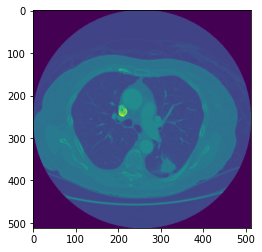

In [114]:
plt.imshow(image)

In [115]:
np.unique(image)

array([-1.58683432, -1.56010518, -1.53337603, -1.50664688, -1.47991773,
       -1.45318859, -1.42645944, -1.39973029, -1.37300114, -1.346272  ,
       -1.31954285, -1.2928137 , -1.26608455, -1.2393554 , -1.21262626,
       -1.18589711, -1.15916796, -1.13243881, -1.10570967, -1.07898052,
       -1.05225137, -1.02552222, -0.99879307, -0.97206393, -0.94533478,
       -0.91860563, -0.89187648, -0.86514734, -0.83841819, -0.81168904,
       -0.78495989, -0.75823075, -0.7315016 , -0.70477245, -0.6780433 ,
       -0.65131415, -0.62458501, -0.59785586, -0.57112671, -0.54439756,
       -0.51766842, -0.49093927, -0.46421012, -0.43748097, -0.41075182,
       -0.38402268, -0.35729353, -0.33056438, -0.30383523, -0.27710609,
       -0.25037694, -0.22364779, -0.19691864, -0.1701895 , -0.14346035,
       -0.1167312 , -0.09000205, -0.0632729 , -0.03654376, -0.00981461,
        0.01691454,  0.04364369,  0.07037283,  0.09710198,  0.12383113,
        0.15056028,  0.17728943,  0.20401857,  0.23074772,  0.25